# NBA Scoring Forecaster

### Determine the number of games for a current NBA player to meet or surpass a career points threshold using self-defined Ordinary Least Squares (OLS) regression model.

### Contents

1. Collect data via web scraping [basketball-reference](https://www.basketball-reference.com/)
2. Prepare data
3. Fit and evaluate OLS model to predict points by career games
4. Determine the number of games to meet or exceed career points threshold

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Pick a player

In [2]:
# pick a player (LeBron, Luka, KD, Giannis, Steph)
str_player = 'KD'
print(f'Selected player: {str_player}')

Selected player: KD


## Determine a threshold

In [3]:
# number of points to reach or surpass
int_pts_goal = 38388
print(f'Career points threshold: {int_pts_goal}')

Career points threshold: 38388


## Define functions

In [4]:
# make output directory
def make_output_directory(str_dirname_output):
    print(f'Output directory: {str_dirname_output}')
    try:
        os.mkdir(str_dirname_output)
    except FileExistsError:
        pass

In [5]:
# define function to get table from url
def get_table(str_url):
    r = requests.get(str_url)
    # get content of page
    soup = BeautifulSoup(r.content, 'html.parser')
    # get the table
    table = soup.find('table', {'id': 'pgl_basic'})
    return table

In [6]:
# collect data
def collect_data(list_int_year, dict_input, str_player, str_dirname_output):
    # create df
    list_dict_row = []
    for int_year in tqdm (list_int_year):
        # get table
        str_url = f"https://www.basketball-reference.com/players/{dict_input[str_player]['str_name']}/gamelog/{int_year}"
        table = get_table(str_url=str_url)
        # get the rows
        list_rows = table.findAll('tr')[1:]
        for row in list_rows:
            # get columns
            list_columns = row.findAll('td')
            try:
                # get columns
                list_columns = row.findAll('td')
                # create row
                dict_row = {
                    'year': int_year,
                    'game_number': int(list_columns[0].text),
                    'date': list_columns[1].text,
                    'points': int(list_columns[26].text),
                }
                # append
                list_dict_row.append(dict_row)
            except IndexError:
                pass
            except ValueError:
                pass
    # create df
    df = pd.DataFrame(list_dict_row)
    # save locally
    str_filename = 'df.csv'
    str_local_path = f'{str_dirname_output}/{str_filename}'
    df.to_csv(str_local_path, index=False)
    # return
    return df

In [7]:
# train-test split
def train_test_split(df, flt_prop_train=0.66, bool_verbose=True):
    int_n_rows_all = df.shape[0]
    int_n_rows_train = round(int_n_rows_all * flt_prop_train)
    df_train = df.copy().iloc[:int_n_rows_train, :]
    df_test = df.copy().iloc[int_n_rows_train:, :]
    # messages
    if bool_verbose:
        print(f'There are {int_n_rows_all} rows in df')
        print(f'There are {int_n_rows_train} rows in df_train')
        print(f'There are {df_test.shape[0]} rows in df_test')
    else:
        pass
    # return
    return df_train, df_test

In [8]:
# x y split
def x_y_split(list_cols_model, str_target, df_train, df_test):
    # train
    X_train = df_train[list_cols_model]
    y_train = df_train[str_target]
    # test
    X_test = df_test[list_cols_model]
    y_test = df_test[str_target]
    # return
    return X_train, y_train, X_test, y_test

In [9]:
# linear regression class
class OLSRegression:
    # initialize class
    def __init__(self):
        pass
    # fit the model
    def fit(self, X, y):
        # ordinary least squares b = (XT*X)^-1 * XT*y
        arr_betas = inv(X.T.dot(X)).dot(X.T).dot(y)
        # create dictionary
        dict_col_betas = dict(zip(X.columns, arr_betas))
        # save to class
        self.dict_col_betas = dict_col_betas
        # return self
        return self
    # generate predictions
    def predict(self, X):
        # multiply each cell by its beta
        list_predictions = list(X.dot(pd.Series(self.dict_col_betas)))
        # save to class
        self.list_predictions = list_predictions
        # return self
        return self
    # evaluate performance
    def evaluate(self, y):
        # get mean absolute error
        mae = mean_absolute_error(y_true=y, y_pred=self.list_predictions)
        # get mean squared error
        mse = mean_squared_error(y_true=y, y_pred=self.list_predictions)
        # get root mean square error
        rmse = np.sqrt(mse)
        # get explained variance (R2)
        r2 = r2_score(y_true=y, y_pred=self.list_predictions)
        # create dictionary
        dict_eval_metrics = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}
        # return dict_eval_metrics
        return dict_eval_metrics

In [10]:
# games to surpass threshold
def games_to_threshold(df, str_predictor, int_pts_goal, dict_col_betas, flt_median_residual, str_target, str_dirname_output):
    flt_predicted_points = 0.0
    int_total_games_played_start = np.max(df[str_predictor])+1
    list_dict_row = []
    while flt_predicted_points < int_pts_goal:
        # get predicted points
        flt_predicted_points = (dict_col_betas[str_predictor] * int_total_games_played_start) + flt_median_residual
        # make row
        dict_row = {
            str_predictor: int_total_games_played_start,
            str_target: flt_predicted_points,
        }
        list_dict_row.append(dict_row)
        # increase int_total_games_played_start
        int_total_games_played_start += 1

    # df
    df_extrapolate = pd.DataFrame(list_dict_row)
    str_filename = 'df_extrapolate.csv'
    str_local_path = f'{str_dirname_output}/{str_filename}'
    df_extrapolate.to_csv(str_local_path, index=False)
    # message
    int_career_game_record = np.max(df_extrapolate[str_predictor])
    print(f'{str_player} is predicted to reach and/or eclipse the chosen points threshold ({int_pts_goal}) in his {int_career_game_record}th career game')
    flt_seasons = df_extrapolate.shape[0] / flt_median_games_per_season
    print(f'This will take about {flt_seasons:0.2f} more seasons ({flt_median_games_per_season} games per season)')
    # return
    return df_extrapolate

## Input dictionary

In [11]:
dict_input = {
    'LeBron': {
        'int_start_year': 2004,
        'str_name': '/j/jamesle01',
    },
    'Luka': {
        'int_start_year': 2019,
        'str_name': 'd/doncilu01',
    },
    'KD': {
        'int_start_year': 2008,
        'str_name': 'd/duranke01',
    },
    'Giannis': {
        'int_start_year': 2014,
        'str_name': 'a/antetgi01',
    },
    'Steph': {
        'int_start_year': 2010,
        'str_name': 'c/curryst01',
    },
    
}

## Make output directory named after selected player

In [12]:
# make output directory
str_dirname_output = f'./{str_player}'
make_output_directory(str_dirname_output=str_dirname_output)

Output directory: ./KD


## Scrape all games played to collect data

In [13]:
# create list of years
int_start_year = dict_input[str_player]['int_start_year'] # rookie season
int_end_year = 2023 # current season
list_int_year = list(range(int_start_year, int_end_year+1))

In [14]:
# collect data
df = collect_data(
    list_int_year=list_int_year, 
    dict_input=dict_input, 
    str_player=str_player, 
    str_dirname_output=str_dirname_output,
)
# show
df

100%|███████████████████████████████████████████| 16/16 [00:03<00:00,  4.37it/s]


,year,game_number,date,points
0,2008,1,2007-10-31,18
1,2008,2,2007-11-01,27
2,2008,3,2007-11-04,24
3,2008,4,2007-11-06,27
4,2008,5,2007-11-07,17
...,...,...,...,...
968,2023,30,2022-12-18,43
969,2023,31,2022-12-21,23
970,2023,32,2022-12-23,24
971,2023,33,2022-12-26,32


## Prep data

In [15]:
str_predictor = 'total_games_played'
str_target = 'cumulative_points'
str_filename = 'df.csv'
str_local_path = f'{str_dirname_output}/{str_filename}'
df = pd.read_csv(str_local_path)
# get total games played
df[str_predictor] = list(range(1, df.shape[0]+1))
# get cumulative points
df[str_target] = np.cumsum(df['points'])
# show
df

,year,game_number,date,points,total_games_played,cumulative_points
0,2008,1,2007-10-31,18,1,18
1,2008,2,2007-11-01,27,2,45
2,2008,3,2007-11-04,24,3,69
3,2008,4,2007-11-06,27,4,96
4,2008,5,2007-11-07,17,5,113
...,...,...,...,...,...,...
968,2023,30,2022-12-18,43,969,26437
969,2023,31,2022-12-21,23,970,26460
970,2023,32,2022-12-23,24,971,26484
971,2023,33,2022-12-26,32,972,26516


## Plot cumulative points by total games played

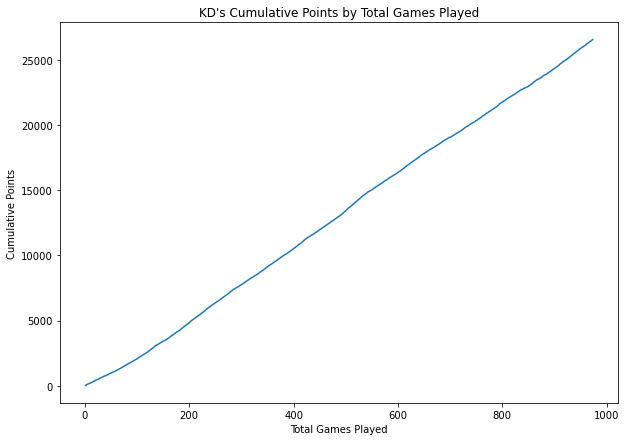

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title(f"{str_player}'s Cumulative Points by Total Games Played")
ax.set_xlabel('Total Games Played')
ax.set_ylabel('Cumulative Points')
ax.plot(df[str_predictor], df[str_target])
str_filename = 'plt_trend.png'
str_local_path = f'{str_dirname_output}/{str_filename}'
plt.savefig(str_local_path, bbox_inches='tight')
plt.show()

## Fit OLS regresson model

In [17]:
# train-test split
df_train, df_test = train_test_split(
    df=df, 
    flt_prop_train=0.66, 
    bool_verbose=True,
)

# x-y split
X_train, y_train, X_test, y_test = x_y_split(
    list_cols_model=[str_predictor], 
    str_target=str_target, 
    df_train=df_train, 
    df_test=df_test,
)
print('')

# initialize model
cls_model_inference = OLSRegression()
# fit model on training data
cls_model_inference.fit(
    X=X_train,
    y=y_train,
)
dict_col_betas = cls_model_inference.dict_col_betas
print('Beta coefficients:')
print(dict_col_betas)
print('')

# in-sample predictions
cls_model_inference.predict(X=X_train)
list_predictions_train = cls_model_inference.list_predictions
# in-sample evaluation
dict_eval_metrics = cls_model_inference.evaluate(y=y_train)
print('In-Sample:')
pprint(dict_eval_metrics)
print('')

# out-of-sample predictions
cls_model_inference.predict(X=X_test)
list_predictions_test = cls_model_inference.list_predictions
# out-of-sample evaluation
dict_eval_metrics = cls_model_inference.evaluate(y=y_test)
print('Out-of-sample:')
pprint(dict_eval_metrics)

There are 973 rows in df
There are 642 rows in df_train
There are 331 rows in df_test

Beta coefficients:
{'total_games_played': 26.68704766699561}

In-Sample:
{'mae': 312.44954120399996,
 'mse': 129542.26892412228,
 'r2': 0.9952541577376801,
 'rmse': 359.91980901879003}

Out-of-sample:
{'mae': 387.18874790742586,
 'mse': 154636.55292225943,
 'r2': 0.976405663416982,
 'rmse': 393.2385445531242}


## Plot distribution of residuals

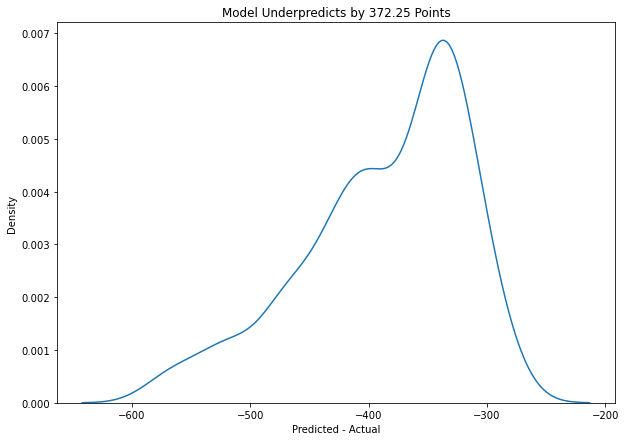

In [18]:
list_residuals = list(list_predictions_test - y_test)
flt_median_residual = np.median(list_residuals)
if flt_median_residual > 0:
    str_over_under = 'Overpredicts'
else:
    str_over_under = 'Underpredicts'
# create title
str_title = f'Model {str_over_under} by {abs(flt_median_residual):0.2f} Points'    
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title(str_title)
ax.set_xlabel('Predicted - Actual')
sns.kdeplot(list_residuals, ax=ax)
str_filename = 'plt_residuals.png'
str_local_path = f'{str_dirname_output}/{str_filename}'
plt.savefig(str_local_path, bbox_inches='tight')
plt.show()

## Plot predicted and actual cumulative points by total games played

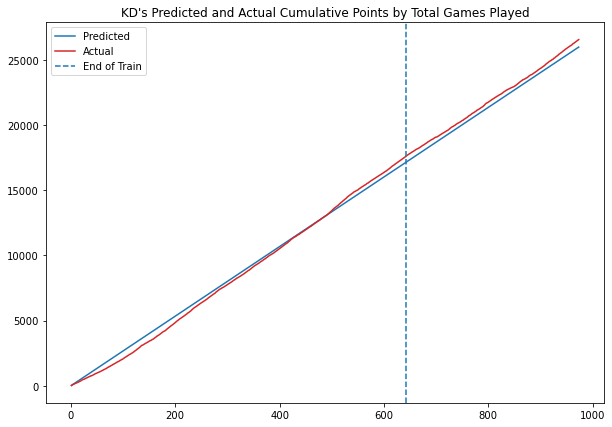

In [19]:
fig, ax = plt.subplots(figsize=(10,7))
y_hat = list_predictions_train + list_predictions_test
ax.set_title(f"{str_player}'s Predicted and Actual Cumulative Points by Total Games Played")
ax.plot(df[str_predictor], y_hat, color='tab:blue', label='Predicted') # predicted
ax.plot(df[str_predictor], df[str_target], color='tab:red', label='Actual') # actual
ax.axvline(np.max(df_train[str_predictor]), linestyle='--', label='End of Train') # end of training data
plt.legend()
str_filename = 'plt_y_hat.png'
str_local_path = f'{str_dirname_output}/{str_filename}'
plt.savefig(str_local_path, bbox_inches='tight')
plt.show()

## Find the number of career games to reach or surpass threshold

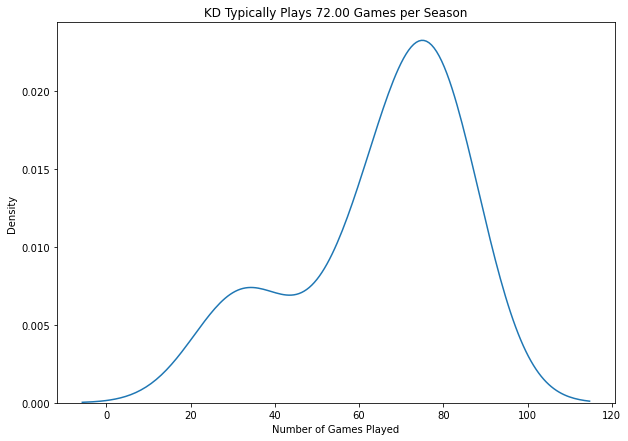

In [20]:
# get games played by season
list_cols = ['year', 'game_number']
df_grouped = df[list_cols].groupby(by='year', as_index=False).max()
flt_median_games_per_season = np.median(df_grouped['game_number'])
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title(f'{str_player} Typically Plays {flt_median_games_per_season:0.2f} Games per Season')
ax.set_xlabel('Number of Games Played')
sns.kdeplot(df_grouped['game_number'], ax=ax)
str_filename = 'plt_games_per_season.png'
str_local_path = f'{str_dirname_output}/{str_filename}'
plt.savefig(str_local_path, bbox_inches='tight')
plt.show()

In [21]:
# get games to threshold
df_extrapolate = games_to_threshold(
    df=df, 
    str_predictor=str_predictor, 
    int_pts_goal=int_pts_goal, 
    dict_col_betas=dict_col_betas, 
    flt_median_residual=flt_median_residual, 
    str_target=str_target, 
    str_dirname_output=str_dirname_output,
)
# show
df_extrapolate.tail(10)

KD is predicted to reach and/or eclipse the chosen points threshold (38388) in his 1453th career game
This will take about 6.67 more seasons (72.0 games per season)


,total_games_played,cumulative_points
470,1444,38163.842776
471,1445,38190.529824
472,1446,38217.216871
473,1447,38243.903919
474,1448,38270.590967
475,1449,38297.278014
476,1450,38323.965062
477,1451,38350.652110
478,1452,38377.339157
479,1453,38404.026205
